# Fisher's Exact Test to determine GO Term Enrichment of Probes

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
BASE = '../data'

grouped_loci = utils.load(os.path.join(BASE,"grouped_loci_filt1.pkl.gz"))

In [3]:
import gseapy as gp
import goatools

obodag = goatools.obo_parser.GODag('go-basic.obo')

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-07-16) 46,953 GO Terms


In [4]:
def make_go2Gene_map(grouped_loci, ontology='MF'):
    ontology_map = {'MF': 'molecular_function', 'BP': 'biological_process', 'CC': 'cellular_component'}
    
    out = defaultdict(set)    
    for l in grouped_loci:
        if 'go' in l.annotations:
            for go in l.annotations['go']:
                if obodag[go].namespace == ontology_map[ontology]:
                    out[go].add(l.cluster_id)
                    for parent in obodag[go].get_all_parents():
                        if obodag[parent].namespace == ontology_map[ontology]:
                            out[parent].add(l.cluster_id)
                
    return out

In [5]:
def filter_go2gene_map(go_locus):
    
    # Remove "very broad" gene sets. Arbitrary definition: gene sets that emcompass >50% of all IDs
    all_ids = set(chain(*go_locus.values()))
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) / len(all_ids) <= 0.5}

    # Remove terms with less than 10 members: 
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) >= 10}

    # Remove child terms with identical gene sets as their parents
    to_remove = set()
    for parent in go_locus.keys():
        # If child term has exact same members as parent, remove
        child_ids = [x.id for x in obodag[parent].children if x.id in go_locus.keys()]
        for child in child_ids:
            if go_locus[child] == go_locus[parent]:
                to_remove.add(child)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    # Remove sibling terms with identical gene sets
    to_remove = set()
    for brother in go_locus.keys():
        for parent in obodag[brother].parents:
            siblings = set([y.id for y in parent.children])
            siblings.remove(brother)
            for sibling in siblings:
                if sibling in go_locus.keys() and go_locus[brother] == go_locus[sibling]:
                    to_remove.add(sibling)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    return go_locus

In [6]:
# pop is group1 + group2
def enrichment_fish(go_in_group, nongo_in_group, go_in_other, nongo_in_other):
    import scipy.stats as stats
        
    if go_in_group != 0:
        go_in_group -= 1
       
    oddsr, pval = stats.fisher_exact([[go_in_group, go_in_other], [nongo_in_group, nongo_in_other]], alternative='two-sided')
    
    samplings = go_in_group + nongo_in_group
    total_go = go_in_group + go_in_other
    total = go_in_group + nongo_in_group + go_in_other + nongo_in_other

    lower, expected = stats.hypergeom.interval(.99, M=total+1, n=total_go+1, N=samplings+1)
    
    return oddsr, pval, expected

In [7]:
group_df = pd.read_csv(os.path.join(BASE,'groups.csv'), index_col=0)
group_df.head()

,RAG_Enriched,RAG_Unenriched,RT_Enriched,RT_Unenriched
115324,True,False,True,False
132035,False,True,False,False
318873,False,True,False,True
376417,False,False,True,True
585756,False,True,False,False


In [8]:
mf_map = filter_go2gene_map(make_go2Gene_map(grouped_loci))
bp_map = filter_go2gene_map(make_go2Gene_map(grouped_loci, ontology='BP'))

In [9]:
def enrichment_df(group1, group2, go_map):
    pv = dict()

    all_annotations = set(go_map.keys())
    
    group_loci = set(group_df.query('{} and ~{}'.format(group1, group2)).index)
    other_loci = set(group_df.query('~({} and ~{})'.format(group1, group2)).index)

    for annotation in all_annotations:
        go_in_group = len(go_map[annotation] & group_loci)
        nongo_in_group = len(group_loci) - go_in_group
        go_in_other =  len(go_map[annotation] & other_loci)
        nongo_in_other = len(other_loci) - go_in_other

        odds_r, p_val, expected = enrichment_fish(go_in_group, nongo_in_group, go_in_other, nongo_in_other)

        pv[annotation] = [odds_r, p_val, go_in_group+go_in_other, go_in_group, expected]

    res = (pd.DataFrame({obodag[k].name:v for k,v in pv.items()})
             .T
             .rename(columns={0:'odds_ratio', 1:'p_value', 2: 'total_annot', 3:'in_group', 4:'expected'})
             .sort_values(by=['p_value']))
    return res

## RT - Enriched vs Uneneriched - MF

In [10]:
(enrichment_df('RT_Enriched', 'RT_Unenriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
cysteine-type peptidase activity,14.932188,3.933534e-09,25.0,21.0,12.0
urocanate hydratase activity,14.807348,4.255323e-05,13.0,11.0,8.0
cysteine-type endopeptidase activity,8.894973,4.370003e-05,17.0,13.0,9.0
alcohol dehydrogenase (NAD) activity,8.146413,1.310452e-04,16.0,12.0,9.0
methionine-tRNA ligase activity,7.880739,1.312347e-03,12.0,9.0,7.0
acetaldehyde dehydrogenase (acetylating) activity,7.399194,3.846174e-04,15.0,11.0,8.0
"ligase activity, forming carbon-nitrogen bonds",3.821171,2.698253e-04,33.0,19.0,15.0
"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds",3.407830,8.136744e-05,46.0,25.0,20.0
aminopeptidase activity,3.252646,9.266119e-03,22.0,12.0,11.0
"oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor",3.205590,5.703773e-11,140.0,72.0,49.0


## RT - Enriched vs Uneneriched - BP

In [11]:
(enrichment_df('RT_Enriched', 'RT_Unenriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
methionyl-tRNA aminoacylation,7.880739,1.312347e-03,12.0,9.0,7.0
carbon utilization,7.399194,3.846174e-04,15.0,11.0,8.0
protein refolding,3.304199,4.756230e-04,39.0,21.0,17.0
ncRNA metabolic process,2.494452,9.868326e-03,36.0,17.0,16.0
cellular amino acid metabolic process,2.454956,1.025639e-13,329.0,144.0,104.0
proteolysis,2.276378,1.761679e-04,96.0,42.0,36.0
protein folding,2.134095,7.502122e-03,56.0,24.0,23.0


## RT - Unenriched vs Enriched - MF

In [12]:
(enrichment_df('RT_Unenriched', 'RT_Enriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
phosphoglycerate mutase activity,9.604270,1.970539e-09,45.0,40.0,29.0
protein-N(PI)-phosphohistidine-sugar phosphotransferase activity,8.521586,6.579289e-04,17.0,15.0,13.0
"exonuclease activity, active with either ribo- or deoxyribonucleic acids and producing 5'-phosphomonoesters",7.908931,1.278260e-03,16.0,14.0,12.0
ribonuclease activity,7.908931,1.278260e-03,16.0,14.0,12.0
RNA polymerase activity,7.184126,8.969472e-22,134.0,114.0,75.0
DNA binding,6.145238,1.745863e-20,141.0,117.0,79.0
"intramolecular transferase activity, phosphotransferases",6.051763,2.573876e-09,60.0,50.0,37.0
polyribonucleotide nucleotidyltransferase activity,5.792275,4.413608e-04,24.0,20.0,17.0
carbohydrate transporter activity,5.678715,2.486167e-03,18.0,15.0,14.0
structural molecule activity,5.580092,1.631410e-40,319.0,257.0,167.0


## RT - Unenriched vs Enriched - BP

In [13]:
(enrichment_df('RT_Unenriched', 'RT_Enriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
movement of cell or subcellular component,72.378500,4.335781e-37,116.0,114.0,66.0
locomotion,72.378500,4.335781e-37,116.0,114.0,66.0
regulation of gene expression,23.197786,3.128689e-06,21.0,20.0,15.0
regulation of metabolic process,7.726220,1.117214e-04,23.0,20.0,17.0
RNA biosynthetic process,7.319011,2.577716e-22,136.0,116.0,76.0
nucleic acid-templated transcription,7.184126,8.969472e-22,134.0,114.0,75.0
amide biosynthetic process,5.443104,4.027500e-23,179.0,145.0,98.0
peptide metabolic process,5.285377,7.699932e-23,180.0,145.0,98.0
RNA processing,5.270447,4.531542e-03,17.0,14.0,13.0
cellular amide metabolic process,5.213351,7.119950e-23,183.0,147.0,100.0


## RAG - Enriched vs Unenriched - MF

In [14]:
(enrichment_df('RAG_Enriched', 'RAG_Unenriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
urocanate hydratase activity,19.158470,6.552542e-06,13.0,11.0,7.0
alcohol dehydrogenase (NAD) activity,10.542670,1.838474e-05,16.0,12.0,8.0
methionine-tRNA ligase activity,10.192657,3.148634e-04,12.0,9.0,6.0
acetaldehyde dehydrogenase (acetylating) activity,9.573770,6.565001e-05,15.0,11.0,8.0
cysteine-type peptidase activity,9.363908,1.835345e-07,25.0,18.0,11.0
cysteine-type endopeptidase activity,6.378871,3.475620e-04,17.0,11.0,8.0
"oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor",4.468381,5.373844e-17,140.0,74.0,42.0
"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides",3.060679,6.617569e-03,28.0,13.0,12.0
"ligase activity, forming carbon-nitrogen bonds",2.979632,3.409011e-03,33.0,15.0,13.0
"oxidoreductase activity, acting on the CH-NH2 group of donors",2.854359,2.353524e-07,115.0,49.0,36.0


## RAG - Enriched vs Unenriched - BP

In [15]:
(enrichment_df('RAG_Enriched', 'RAG_Unenriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
methionyl-tRNA aminoacylation,10.192657,3.148634e-04,12.0,9.0,6.0
carbon utilization,9.573770,6.565001e-05,15.0,11.0,8.0
one-carbon metabolic process,5.719260,7.860017e-03,11.0,7.0,6.0
protein refolding,4.284837,1.417764e-05,39.0,21.0,15.0
protein folding,3.220370,3.586889e-05,56.0,26.0,20.0
alcohol metabolic process,2.789079,3.837672e-03,39.0,17.0,15.0
cellular amino acid metabolic process,2.694761,2.019273e-15,329.0,130.0,87.0
organic hydroxy compound metabolic process,2.667049,4.443917e-03,40.0,17.0,15.0


## RAG - Unenriched vs Enriched - MF

In [16]:
(enrichment_df('RAG_Unenriched', 'RAG_Enriched', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
"ATPase activity, coupled to transmembrane movement of ions, rotational mechanism",26.041918,2.457833e-12,40.0,38.0,25.0
ribonuclease activity,19.469697,4.729248e-05,16.0,15.0,12.0
"exonuclease activity, active with either ribo- or deoxyribonucleic acids and producing 5'-phosphomonoesters",19.469697,4.729248e-05,16.0,15.0,12.0
phosphoglycerate mutase activity,19.272927,7.740315e-13,45.0,42.0,27.0
hydrogen ion transmembrane transporter activity,17.833333,8.741417e-12,42.0,39.0,26.0
"oxidoreductase activity, acting on X-H and Y-H to form an X-Y bond",13.876890,1.148267e-03,12.0,11.0,9.0
inorganic cation transmembrane transporter activity,10.979046,1.643752e-10,45.0,40.0,27.0
active ion transmembrane transporter activity,10.691667,3.381439e-10,44.0,39.0,27.0
"ATPase activity, coupled",9.385291,2.902097e-10,47.0,41.0,28.0
cation transmembrane transporter activity,9.385291,2.902097e-10,47.0,41.0,28.0


## RAG - Unenriched vs Enriched - BP

In [17]:
(enrichment_df('RAG_Unenriched', 'RAG_Enriched', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
movement of cell or subcellular component,40.682039,1.914435e-37,116.0,112.0,62.0
locomotion,40.682039,1.914435e-37,116.0,112.0,62.0
"energy coupled proton transport, down electrochemical gradient",27.479704,4.681527e-13,42.0,40.0,26.0
nucleoside triphosphate biosynthetic process,14.088913,1.140026e-11,45.0,41.0,27.0
ATP biosynthetic process,13.729155,2.500297e-11,44.0,40.0,27.0
organic cyclic compound catabolic process,10.234783,3.557139e-06,26.0,23.0,17.0
ion transmembrane transport,9.899614,1.508122e-12,57.0,50.0,34.0
RNA processing,9.731061,3.917280e-04,17.0,15.0,12.0
hydrogen transport,9.204144,8.942872e-13,61.0,53.0,36.0
"energy coupled proton transmembrane transport, against electrochemical gradient",8.667123,4.441286e-09,44.0,38.0,27.0


## Both - Unenriched vs Enriched - MF

In [18]:
(enrichment_df('(RAG_Unenriched or RT_Unenriched)', '(RT_Enriched or RAG_Enriched)', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
"ATPase activity, coupled to transmembrane movement of ions, rotational mechanism",21.095226,1.674480e-10,40.0,38.0,27.0
protein-N(PI)-phosphohistidine-sugar phosphotransferase activity,16.930120,1.464067e-04,17.0,16.0,13.0
hydrogen ion transmembrane transporter activity,14.444444,7.063745e-10,42.0,39.0,28.0
"oxidoreductase activity, acting on X-H and Y-H to form an X-Y bond",11.259615,4.267422e-03,12.0,11.0,10.0
phosphoglycerate mutase activity,8.891468,1.374818e-08,45.0,40.0,30.0
inorganic cation transmembrane transporter activity,8.891468,1.374818e-08,45.0,40.0,30.0
active ion transmembrane transporter activity,8.659259,2.544200e-08,44.0,39.0,29.0
carbohydrate transporter activity,8.461446,8.357271e-04,18.0,16.0,14.0
cation transmembrane transporter activity,7.600000,1.926880e-08,47.0,41.0,31.0
"ATPase activity, coupled",7.600000,1.926880e-08,47.0,41.0,31.0


## Both - Enriched vs Unenriched - MF

In [19]:
(enrichment_df('(RT_Enriched or RAG_Enriched)', '(RAG_Unenriched or RT_Unenriched)', mf_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
cysteine-type peptidase activity,14.753584,4.648525e-09,25.0,21.0,12.0
urocanate hydratase activity,14.631439,4.625653e-05,13.0,11.0,8.0
cysteine-type endopeptidase activity,8.789146,4.809354e-05,17.0,13.0,9.0
alcohol dehydrogenase (NAD) activity,8.049556,1.429541e-04,16.0,12.0,9.0
methionine-tRNA ligase activity,7.787234,1.398027e-03,12.0,9.0,7.0
acetaldehyde dehydrogenase (acetylating) activity,7.311279,4.158987e-04,15.0,11.0,8.0
"ligase activity, forming carbon-nitrogen bonds",3.775492,2.866084e-04,33.0,19.0,15.0
"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds",3.686994,1.850312e-05,46.0,26.0,20.0
"hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in linear amides",3.663024,1.189514e-03,28.0,16.0,13.0
aminopeptidase activity,3.213956,9.668215e-03,22.0,12.0,11.0


In [20]:
(enrichment_df('(RT_Enriched or RAG_Enriched)', '(RAG_Unenriched or RT_Unenriched)', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
methionyl-tRNA aminoacylation,7.787234,1.398027e-03,12.0,9.0,7.0
carbon utilization,7.311279,4.158987e-04,15.0,11.0,8.0
protein refolding,3.264636,4.947061e-04,39.0,21.0,17.0
cellular amino acid metabolic process,2.422449,2.083523e-13,329.0,144.0,104.0
proteolysis,2.248656,1.885222e-04,96.0,42.0,36.0
protein folding,2.108462,7.952959e-03,56.0,24.0,23.0


In [21]:
(enrichment_df('(RAG_Unenriched or RT_Unenriched)', '(RT_Enriched or RAG_Enriched)', bp_map)
 .query('odds_ratio > 1 and p_value < 0.01 and total_annot < 500')
 .sort_values('odds_ratio', ascending=False))

,odds_ratio,p_value,total_annot,in_group,expected
locomotion,inf,5.089614e-39,116.0,116.0,68.0
movement of cell or subcellular component,inf,5.089614e-39,116.0,116.0,68.0
ATP hydrolysis coupled transmembrane transport,23.421425,9.908393e-12,44.0,42.0,29.0
"energy coupled proton transmembrane transport, against electrochemical gradient",23.421425,9.908393e-12,44.0,42.0,29.0
"energy coupled proton transport, down electrochemical gradient",22.257192,4.080893e-11,42.0,40.0,28.0
hydrogen transport,21.869159,9.054148e-16,61.0,58.0,39.0
regulation of gene expression,21.486239,9.413390e-06,21.0,20.0,16.0
ion transmembrane transport,20.294551,2.725779e-14,57.0,54.0,36.0
nucleoside triphosphate biosynthetic process,11.409756,1.293290e-09,45.0,41.0,30.0
ATP biosynthetic process,11.119088,2.465689e-09,44.0,40.0,29.0


In [22]:
group1 = '(RAG_Unenriched or RT_Unenriched)'
group2 = '(RT_Enriched or RAG_Enriched)'

group_loci = set(group_df.query('{}'.format(group1)).index)
other_loci = set(group_df.query('{}'.format(group2)).index)

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


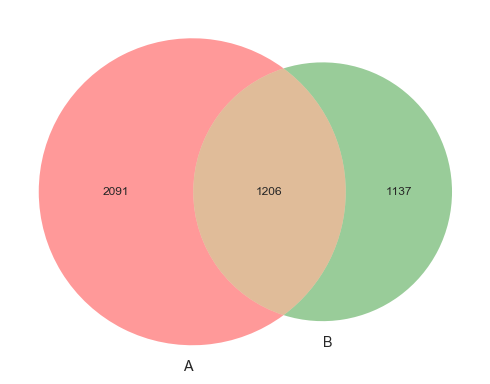

In [23]:
from matplotlib_venn import venn2
venn2([group_loci, other_loci])